# Project: Evaluation of neural network architectures on MNIST datasets

## Group Members : Yidong HUANG, Simon ROBER, Marck-Edward KEMEH

### ABOUT
The MNIST dataset is a large database of handwritten digits used in many forms of image processing.
This dataset contains 60,000 training images and 10,000 test images. Our aim is to design some neural 
networks that can recognise these hand-written digits. our projects will be based on two different networks
for this task.                   

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import scikitplot as skplt
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.metrics import roc_curve

We begin by splitting the MNIST dataset into two. A set for training and another for testing.
We then normalize the test set and training set by dividing with 255 so that the values can be between 0 and 1.
Because we will be working with convolutional neural network, we need to change the original shape of the MNIST dataset which is (60000, 28, 28) to that of the convolutional neural network (60000, 28, 28, 1).
This section is just to prepare our dataset for the network.

In [2]:
# dividing dataset into train and test set, also reshaping dataset to fit input of network
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0
print('shape before adding dimension is :' ,x_train.shape)
x_train, x_test = np.expand_dims(x_train, axis= -1), np.expand_dims(x_test, axis = -1)
x_train = x_train.reshape(x_train.shape[0],28,28,1)
x_test = x_test.reshape(x_test.shape[0],28,28,1)
print ('shape after adding dimension is :' ,x_train.shape)

shape before adding dimension is : (60000, 28, 28)
shape after adding dimension is : (60000, 28, 28, 1)


### First Model
Our first model is a simple network definition which will be used to train the neural network.
Our input shape has to match that of the train set as did above and we are using relu as activation


In [11]:
#first simple model

model1 = keras.Sequential()
model1.add(layers.Input(shape = (28,28,1)))
model1.add(layers.Conv2D(32, (3,3), padding ='valid', activation = 'relu'))
model1.add(layers.MaxPool2D((2,2), (2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(10, activation = 'softmax'))
model1.summary()
model1.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


We now test using our test set against the model we trained to determine if the model actually learned to recognise the digits. For each epoch, we can see the loss rate is decreasing which tells us the model is actually improving on the learning.

In [12]:
#training
model1.fit(x_train, y_train, epochs = 4)

Epoch 1/4
60000/60000 [==============================] - 21s 355us/sample - loss: 0.2135 - acc: 0.9391
Epoch 2/4
60000/60000 [==============================] - 21s 357us/sample - loss: 0.0785 - acc: 0.9772
Epoch 3/4
60000/60000 [==============================] - 21s 351us/sample - loss: 0.0589 - acc: 0.9828
Epoch 4/4
60000/60000 [==============================] - 20s 328us/sample - loss: 0.0490 - acc: 0.9848


Next we use the accuracy to determine how well our classifier classifies on the test set to make sure we are not over fitting.


In [3]:
def accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print("test loss is : {0} - test accuracy is : {1}".format(test_loss, test_acc))

    
# Accuracy:
accuracy(model1, x_test, y_test)

NameError: name 'model1' is not defined

#### ROC
We implement the ROC curve and Precision-Recall curve to view the performance of our model on the test set

In [4]:
def roc_curve(model, x_test, y_test):
    y_true = y_test # Given ground truth
    y_probas = model.predict(x_test)
    skplt.metrics.plot_roc(y_true, y_probas, figsize=(6,6))     # https://scikit-plot.readthedocs.io/en/stable/metrics.html
    plt.show()

# ROC:
roc_curve(model1, x_test, y_test)

def precision_recall(model, x_test, y_test):
    y_probas = model.predict(x_test)
    skplt.metrics.plot_precision_recall(y_test, y_probas)
    plt.show()
    
# Precision-Recall:
precision_recall(model1, x_test, y_test)

NameError: name 'model1' is not defined

**TODO: interpret results of Roc Curve, Precision recall!!! **

### Second Model
Below is our second model which follows LeNet architecture and has an input shape of (32, 32, 1). Again we define the network, train it and see how it performs in terms of accuracy, Roc curve and Precision-Recall curve.

In [15]:
model2 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])


model2.summary()
model2.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2.fit(x_train, y_train, epochs = 4)
# Accuracy:
accuracy(model2, x_test, y_test)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d_2 (Average (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_3 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_6 (Dense)              (None, 84)               

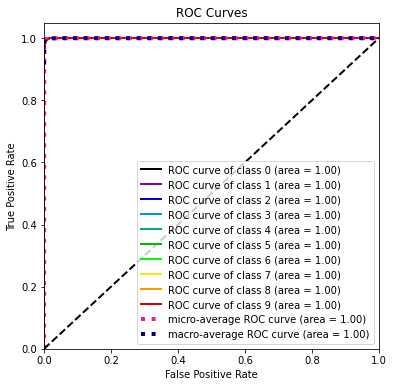

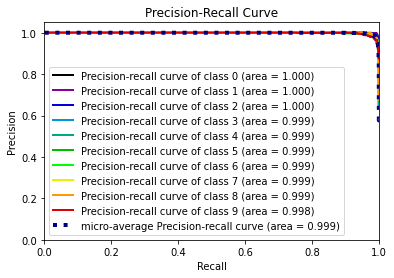

In [16]:
roc_curve(model2, x_test, y_test)
precision_recall(model2, x_test, y_test)

**TODO: interpret results of Roc Curve, Precision recall!!! + Add comments to the model.**

As you can see we now use all the previous defined functions to build the second model.
These first two model were our first experience playing around with Keras and with the CNN. In the next section we will look into the parameters in a more systematic maner. We will build on the second model described above and alter one parameter everytime

#### Comparison model one and model two 

At the default learning learning rate and basic definitions of each models, model 1 learns in a very short time and more accurately than model 2. model1 learns at an average ETA of 30s per epoch while model2 learns at an average ETA of 137s per epoch

#### Learning Rate

By default the learning rate of the model with Adam is 0.001. Lets increase and decease the learning rate slightly to see what the effect is.

In [13]:
model2_increase_lr = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])

model2_increase_lr.compile(optimizer = tf.keras.optimizers.adam(learning_rate=0.01)
, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

model2_increase_lr.fit(x_train, y_train, epochs = 4)

accuracy(model2_increase_lr, x_test, y_test)
roc_curve(model2_increase_lr, x_test, y_test)
precision_recall(model2_increase_lr, x_test, y_test)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d_2 (Average (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_3 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_6 (Dense)              (None, 84)               

AttributeError: module 'tensorflow.python.keras.api._v1.keras.optimizers' has no attribute 'adam'

In [ ]:
model2_decrease_lr = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])

model2_decrease_lr.compile(optimizer = tf.keras.optimizers.adam(learning_rate=0.0001)
, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

model2_decrease_lr.fit(x_train, y_train, epochs = 4)

accuracy(model2_decrease_lr, x_test, y_test)
roc_curve(model2_decrease_lr, x_test, y_test)
precision_recall(model2_decrease_lr, x_test, y_test)

The vanilla second model had an accuracy of about 0.9875. By increasing the learning rate times 10 the accuracy  drops slightly to about 0.9839 . When decreasing the learning rate through a division of 10 the accuracy also drops, but now even worse to about 0.9646 .

Let us take a look at the different curves. The vanilla version had an almost perfect precision-recall curve, where half of the labels were labeled correctly all the time and the other labels 99% of the times. Yet both increasing and decreasing the learning rate deteriorates the good results by serveral percentages. Here again the decreasing model performs worse then the increasing model.

**TODO: ROC Curve**

When the learning rate is too large, then the algorithm might overshoot its goal, but when the learning rate is too small it might never reach the local minimum (or at least take to much time). Our initial learning rate seems to lie in the desired interval, since increasing or decreasing the learning rare reduces performance. The interval is still quite large: from 0.01 to 0.0001. An imporovement to the model would be to further narrow down this interval to optimise the choice for the learning rate.

#### Batch Size

Batch size describe the number of datapoints used in gradient descent, a larger batch size can help you train the model more quickly however at the cost of accuracy. A smaller batch size causes more noise but can reduce generalization error thus have a higher accuracy. Another adventage is that when using GPU, smaller batch size can allow paralle execution since a smaller batch can fit easier in the memory unit.

In [3]:

#batch size is defaut to 32

model2_batch_size3 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])


model2_batch_size3.summary()
model2_batch_size3.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2_batch_size3.fit(x_train, y_train, batch_size=8, epochs = 4)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [4]:
model2_batch_size2 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])


model2_batch_size2.summary()
model2_batch_size2.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2_batch_size2.fit(x_train, y_train, batch_size=16, epochs = 4)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d_2 (Average (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_3 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_4 (Dense)              (None, 84)               

In [5]:
model2_batch_size = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])


model2_batch_size.summary()
model2_batch_size.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2_batch_size.fit(x_train, y_train, batch_size=64, epochs = 4)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d_4 (Average (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_5 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_7 (Dense)              (None, 84)               

In [6]:
model2_batch_size4 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])


model2_batch_size4.summary()
model2_batch_size4.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2_batch_size4.fit(x_train, y_train, batch_size=128, epochs = 4)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d_6 (Average (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_7 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_10 (Dense)             (None, 84)               

#### Number of epochs

An epoch refers to one full cycle through the training data. Until this point we have been training with four epochs. This means that the classifier looks at every training example four times in total to train the network. As seen above when fitting the network, we get the following output:

```
Epoch 1/4
60000/60000 [==============================] - 20s 338us/sample - loss: 0.2497 - acc: 0.9249
Epoch 2/4
60000/60000 [==============================] - 19s 311us/sample - loss: 0.0817 - acc: 0.9747
Epoch 3/4
60000/60000 [==============================] - 21s 343us/sample - loss: 0.0558 - acc: 0.9823
Epoch 4/4
60000/60000 [==============================] - 20s 334us/sample - loss: 0.0430 - acc: 0.9865
```


Notice how each epoch requires about the same amount of time, but the more epochs you use, the more time it requires to train the network. Also notice how the loss decreases and the accuracy increases with each extra epoch. This reveals a certain trade-off; accuracy or shorter training time. Of course we cannot keep increasing the amount of epochs for ever and expect an continuing increase of the accuracy. At a ceratain point the loss will start to increase because of overfitting. Let us look for the amount of epochs where the loss starts to rise again. This is the optimal in terms of loss, since it is the local minimum.

Now to save you the time of running the blow 15 epochs, the results will be displayed after the code.

In [ ]:
model2_epochs = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])


model2_epochs.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2_epochs.fit(x_train, y_train, epochs = 15)

```
Epoch 1/30
60000/60000 [==============================] - 26s 438us/sample - loss: 0.2179 - acc: 0.9363
Epoch 2/30
60000/60000 [==============================] - 23s 390us/sample - loss: 0.0717 - acc: 0.9779
Epoch 3/30
60000/60000 [==============================] - 24s 396us/sample - loss: 0.0518 - acc: 0.9840
Epoch 4/30
60000/60000 [==============================] - 24s 401us/sample - loss: 0.0416 - acc: 0.9869
Epoch 5/30
60000/60000 [==============================] - 29s 483us/sample - loss: 0.0340 - acc: 0.9895
Epoch 6/30
60000/60000 [==============================] - 27s 456us/sample - loss: 0.0283 - acc: 0.9912
Epoch 7/30
60000/60000 [==============================] - 28s 460us/sample - loss: 0.0229 - acc: 0.9926
Epoch 8/30
60000/60000 [==============================] - 28s 468us/sample - loss: 0.0195 - acc: 0.9941
Epoch 9/30
60000/60000 [==============================] - 34s 560us/sample - loss: 0.0179 - acc: 0.9942
Epoch 10/30
60000/60000 [==============================] - 39s 643us/sample - loss: 0.0151 - acc: 0.9953
Epoch 11/30
60000/60000 [==============================] - 33s 549us/sample - loss: 0.0143 - acc: 0.9953
Epoch 12/30
60000/60000 [==============================] - 33s 554us/sample - loss: 0.0106 - acc: 0.9964
Epoch 13/30
60000/60000 [==============================] - 29s 490us/sample - loss: 0.0108 - acc: 0.9963
```

After 12 epochs the loss show a small increase. So the optimal amount of epochs for this CNN is 12. Now when appling more epochs we see that the loss starts to fluctuate and decreases gently. This is expected, but overfitting  makes the classifier unreliable.

Note that running this code again might result in some different values. Yet the same reasoning holds.

#### Kernel size

In this section, we would like to see the results of varied kernel sizes on our model. 
As seen from the roiginial second model with kernel sizes (3, 3) at each layer, we get an accuracy of 0.984 on the test set as defined below:

    10000/10000 [==============================] - 2s 159us/sample - loss: 0.0459 - acc: 0.9841
    test loss is : 0.04586207606535172 - test accuracy is : 0.9840999841690063

We set the first layer of the network with kernel size of (5, 5) and the second remains same at (3, 3) and we get an accuracy of 0.983 on the test set as shown below. This is an improvement on the original model with both kernels at (3, 3).
    
    10000/10000 [==============================] - 3s 307us/sample - loss: 0.0525 - accuracy: 0.9835
    test loss is : 0.05253282631125767 - test accuracy is : 0.9835000038146973
    
Changing the kernal size of first layer to (6, 6) gives an accuracy of  0.986 and (2, 2) gives an accuracy of 0.986.

    10000/10000 [==============================] - 3s 339us/sample - loss: 0.0408 - accuracy: 0.9862
    test loss is : 0.0407773371128249 - test accuracy is : 0.9861999750137329
    

In [16]:
model2 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])


#model2.summary()
model2.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2.fit(x_train, y_train, epochs = 4)
# Accuracy:
accuracy(model2, x_test, y_test)

Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 131s 2ms/sample - loss: 0.2081 - accuracy: 0.9390
Epoch 2/4
60000/60000 [==============================] - 141s 2ms/sample - loss: 0.0692 - accuracy: 0.9790
Epoch 3/4
60000/60000 [==============================] - 146s 2ms/sample - loss: 0.0496 - accuracy: 0.9854
Epoch 4/4
10000/10000 [==============================] - 4s 376us/sample - loss: 0.0328 - accuracy: 0.9896
test loss is : 0.03284961047746474 - test accuracy is : 0.9896000027656555


we can see changing the kernel size alone does not significantly increase the accuracy of the model
###### NOTE 
rerunning th above code might give different results

## Loss functions
throughout our work, we have used the sparse_categorical_crossentropy loss on our model

Still experimenting on our second model, we woud like to see the effects of different loss functions.
#### Mean Squared Error (MSE)- 
MSE measures the average squared difference between the estimated values and the actual values.
With MSE, it is a requirement that the output layer has just one node and also he linear activation function is used in this respect

In [22]:
model2 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=1, activation = 'linear')   
    ])


#model2.summary()

model2.compile(optimizer = "adam", loss = "mse",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2.fit(x_train, y_train, epochs = 4)
# Accuracy:
accuracy(model2, x_test, y_test)

Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 134s 2ms/sample - loss: 1.7078 - accuracy: 0.1725
Epoch 2/4
60000/60000 [==============================] - 140s 2ms/sample - loss: 0.5263 - accuracy: 0.1968
Epoch 3/4
60000/60000 [==============================] - 139s 2ms/sample - loss: 0.3594 - accuracy: 0.2016
Epoch 4/4
10000/10000 [==============================] - 2s 241us/sample - loss: 0.3036 - accuracy: 0.2084
test loss is : 0.3035802862644196 - test accuracy is : 0.20839999616146088


Choosing the MSE as the loss function is not the best choice. We have 10 different
numbers to predict where each is assigned to a neuron on the output layer. But MSE 
requires only one neuron on the output layer which is good for predicting just one type of value.
we can clearly see from above that this performs poorly for our type of data. 
Also since MSE loss is for regression, it cannot be used for this classification model.


#### categorical crossentropy Loss
to use this loss function, we need to hot encode one of the target set.

This is to ensure that each example has an expected probability of 1.0 for the actual class value and an expected probability of 0.0 for all other class values. The efficiency of this loss is almost the same as sparse_categorical_crossentropy.

In [41]:
from keras.utils import to_categorical

#hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


model2 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')   
    ])

#y_binary = to_categorical(y_train)
#x_binary = to_categorical(x_train)
#model2.summary()

model2.compile(optimizer = "adam", loss = "categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2.fit(x_train, y_train, epochs = 4)
# Accuracy:
accuracy(model2, x_test, y_test)

shape before adding dimension is : (60000, 28, 28)
shape after adding dimension is : (60000, 28, 28, 1)
Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 131s 2ms/sample - loss: 0.2338 - accuracy: 0.9281
Epoch 2/4
60000/60000 [==============================] - 129s 2ms/sample - loss: 0.0751 - accuracy: 0.9770
Epoch 3/4
60000/60000 [==============================] - 136s 2ms/sample - loss: 0.0534 - accuracy: 0.9832
Epoch 4/4
60000/60000 [==============================] - 14s 228us/sample - loss: 0.0264 - accuracy: 0.9919
test loss is : 0.026388362831133418 - test accuracy is : 0.9918666481971741


this even gives us a more acuracy of 0.99


#### kullback leibler divergence Loss

In [ ]:
from keras.utils import to_categorical

#hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train, x_test = x_train/255.0, x_test/255.0
#print('shape before adding dimension is :' ,x_train.shape)
x_train, x_test = np.expand_dims(x_train, axis= -1), np.expand_dims(x_test, axis = -1)
x_train = x_train.reshape(x_train.shape[0],28,28,1)
x_test = x_test.reshape(x_test.shape[0],28,28,1)
#print ('shape after adding dimension is :' ,x_train.shape)


model2 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')   
    ])


#model2.summary()

model2.compile(optimizer = "adam", loss = "kullback_leibler_divergence",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2.fit(x_train, y_train, epochs = 4)
# Accuracy:
accuracy(model2, x_test, y_test)

Using TensorFlow backend.


Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 113s 2ms/sample - loss: 0.1990 - accuracy: 0.9407
Epoch 2/4
23968/60000 [==========>...................] - ETA: 1:10 - loss: 0.0771 - accuracy: 0.9768

#### Types of Pooling

According to the lecture notes pooling is a form of down-sampling that partitions the image into non-overlapping regions and computes a representation value for each region. Now there are several ways to achieve this, we will limmit ourselfves to the difference between average pooling and max pooling, since they are the most used. In the vanilla model we already experimented with average pooling, so now we will explore max pooling:

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 6)         60        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_12 (Dense)             (None, 84)               

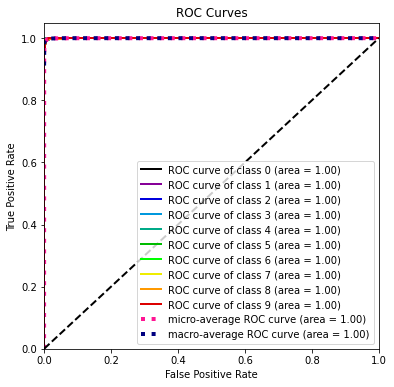

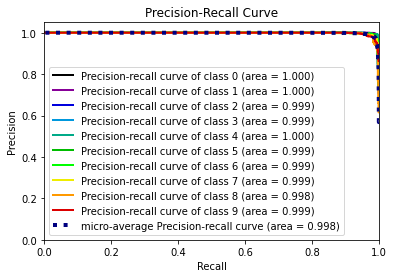

In [18]:
model2 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.MaxPool2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.MaxPool2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])

model2.summary()
model2.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

model2.fit(x_train, y_train, epochs = 4)

accuracy(model2, x_test, y_test)
roc_curve(model2, x_test, y_test)
precision_recall(model2, x_test, y_test)

When comparing both types of pooling, we notice that they perform about equally well in term of accuracy, roc and percision recall. 

#### number of filters
Filters are used to create feature maps.
we would want to see the effects of different filter sizes on our model. We have so far used 6 filters on the first convolutional layer and 16 on the second convolutional layer.
Below, we analyze the effects of 4 filters on the first layer and 6 filters on the second convolutional layer.

In [5]:
model2 = keras.Sequential([
        layers.Conv2D(filters=4, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])


#model2.summary()
model2.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2.fit(x_train, y_train, epochs = 4)
# Accuracy:
accuracy(model2, x_test, y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 4)         40        
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 6)         222       
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 6)           0         
_________________________________________________________________
flatten (Flatten)            (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               18120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

Below we observe another definition of 20 and 4 filters on the first and second convolutional layers respectively 

In [ ]:
model2 = keras.Sequential([
        layers.Conv2D(filters=20, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=4, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])


#model2.summary()
model2.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2.fit(x_train, y_train, epochs = 4)
# Accuracy:
accuracy(model2, x_test, y_test)

From the above two changes we made, We observe changing the number of filters alone does not significantly affect the accuracy of the model. We realised at least two parameters needs to be changed to have an observable change in the accuracy of training.